## Importy

In [1]:
import pandas as pd
import numpy as np
import string
import json
from IPython.display import display
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from emoji import UNICODE_EMOJI
import re
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from  datetime import datetime

pd.options.display.max_columns = None
# Use 'display(df)' instead of 'df' to display all columns.

[nltk_data] Downloading package wordnet to /home/adam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/adam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Ładowanie danych

### US region

In [24]:
ytUS_df = pd.read_csv("./data/youtube_data/US_videos_5p.csv", sep=';')
ytUS_df["region"] = "US"
print(ytUS_df.shape)
ytUS_df.head(1)

(40949, 17)


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,region
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,NaN,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,US


### GB region

In [25]:
# Encoding error. Open GB_videos_5p.csv in VSCode and save file as UTF-16 LE.
ytGB_df = pd.read_csv("./data/youtube_data/GB_videos_5p.csv", sep=';', encoding='utf_16')
ytGB_df["region"] = "GB"
print(ytGB_df.shape)
ytGB_df.head(1)

(38916, 17)


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,region
0,Jw1Y-zhQURU,17.14.11,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,NaN,2017-11-10T07:38:29.000Z,"christmas|""john lewis christmas""|""john lewis""|...",7224515,55681,10247,9479,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,False,False,False,Click here to continue the story and make your...,GB


### Scalenie obu regionów

In [26]:
df = pd.concat([ytGB_df, ytUS_df], ignore_index=True)
print(df.shape)
shapeOld = df.shape
df.rename(columns={"description ": "description"}, inplace=True)
df.head(1)

(79865, 17)


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,region
0,Jw1Y-zhQURU,17.14.11,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,NaN,2017-11-10T07:38:29.000Z,"christmas|""john lewis christmas""|""john lewis""|...",7224515,55681,10247,9479,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,False,False,False,Click here to continue the story and make your...,GB


## Dodanie nowych kolumn

In [27]:
RE_HTTP = re.compile("http[s]?://[/\.a-zA-Z0-9]+")
def getListOfURLs(text):
    return RE_HTTP.findall(str(text))

def countEmojis(text):
    count = 0
    for em in UNICODE_EMOJI['en'].keys():
        if em in str(text):
            count += 1
    return count

def checkIf_FB_TWI_INST_InListOfURLs(list_of_urls):
    isFb = False
    isTwi = False
    isInst = False
    for url in list_of_urls:
        url = url.lower()
        if re.search('facebook', url) or re.match('fb.com', url):
            isFb = True
        elif re.search('twitter', url):
            isTwi = True
        elif re.search('instagram', url):
            isInst = True
    
    return isFb, isTwi, isInst

def checkIfFacebookInListOfURLs(list_of_urls):
    isFacebook = False

    for url in list_of_urls:
        url = url.lower()
        if re.search('facebook', url) or re.match('fb.com', url):
            isFacebook = True
    return isFacebook

def checkIfInstagramInListOfURLs(list_of_urls):
    isInstagram = False
    for url in list_of_urls:
        url = url.lower()
        if re.search('instagram', url):
            isInstagram = True 
    return isInstagram

def checkIfTwitterInListOfURLs(list_of_urls):
    isTwitter = False
    for url in list_of_urls:
        url = url.lower()
        if re.search('twitter', url):
            isTwitter = True
    return isTwitter

# formatowanie czasu i rozbicie na atrybuty  
def addColumnsAndSaveCSV(df, pathToSave):
    ###### Adam ######
    for index, row in df.iterrows():    
        pubdate = datetime.strptime(row['publish_time'],'%Y-%m-%dT%H:%M:%S.%fZ')
        df.loc[index,'pub_date'] = pubdate
        df.loc[index,'pub_day_of_the_week'] = pubdate.weekday()
        df.loc[index,'pub_year'] = pubdate.year
        df.loc[index,'pub_month'] = pubdate.month
        df.loc[index,'pub_day'] = pubdate.day
        df.loc[index,'pub_hour'] = pubdate.hour
        trendate = datetime.strptime(row['trending_date'] + ' 23:59:59','%y.%d.%m %H:%M:%S') # Wymuszamy godzinę 23:59:59
        df.loc[index,'tren_date'] = trendate
        df.loc[index,'tren_day_of_the_week'] = trendate.weekday()
        df.loc[index,'tren_year'] = trendate.year
        df.loc[index,'tren_month'] = trendate.month
        df.loc[index,'tren_day'] = trendate.day
        df.loc[index,'time_to_trend_in_days'] = (trendate - pubdate).total_seconds()/(3600*24)

    df.loc[df['dislikes'] == 0, 'dislikes'] = 1
    df.loc[df['comment_count'] == 0, 'comment_count'] = 1
    df.loc[df['views'] == 0, 'views'] = 1
    df.loc[df['likes'] == 0, 'likes'] = 1

    # stosunek likes, dislikes, views
    df['dislikes/likes'] = df['dislikes']/df['likes']
    df['likes/views'] = df['likes']/df['views']
    df['dislikes/views'] = df['dislikes']/df['views']
    df['comment_count/views'] = df['comment_count']/df['views']
    unique = df['video_id'].unique()

    for uid in unique:
        temp = df[df['video_id']==uid]
        times_in_trend = len(temp)
        increase_views = 0
        increase_likes = 0
        increase_dislikes = 0
        increase_comms = 0
        indexes =  temp.index.values.tolist() 
        if times_in_trend > 1:
            increase_views = temp['views'][indexes[1]] - temp['views'][indexes[0]]
            increase_likes = temp['likes'][indexes[1]] - temp['likes'][indexes[0]]
            increase_dislikes = temp['dislikes'][indexes[1]] - temp['dislikes'][indexes[0]]
            increase_comms = temp['comment_count'][indexes[1]] - temp['comment_count'][indexes[0]]

        df.loc[indexes[0],'increase_views'] = increase_views
        df.loc[indexes[0],'increase_likes'] = increase_likes
        df.loc[indexes[0],'increase_dislikes'] = increase_dislikes
        df.loc[indexes[0],'increase_comms'] = increase_comms
        df.loc[indexes[0],'times_in_trend'] = times_in_trend
        df.loc[indexes[0],'avg_views'] = np.mean(temp['views'])
        df.loc[indexes[0],'avg_likes'] = np.mean(temp['likes'])
        df.loc[indexes[0],'avg_dislikes'] = np.mean(temp['dislikes'])
        df.loc[indexes[0],'avg_comms'] = np.mean(temp['comment_count'])
#         df.loc[indexes[0],'avg_views_increase_per_hour'] = temp['views'][0] / temp['time_to_trend_in_days'][0]
    df = df[df['avg_comms'] >= 0] 
    
    df["avg_views_increase_per_hour"] = df.apply(lambda row: row.views/row.time_to_trend_in_days, axis=1)
    ###### Marcin ######
    df["title_length"] = df.apply(lambda row: len(row.title), axis=1)

    df["description_length"] = df.apply(lambda row: len(str(row.description)), axis=1)

    df['tags'] = df['tags'].apply(lambda tags: json.dumps(tags.replace('"','').split('|')))
    df["n_of_tags"] = df.apply(lambda row: len(json.loads(row.tags)), axis=1)

    df["title_capital_letters"] = df.apply(lambda row: sum(1 for l in row.title if l.isupper()), axis=1)
    df["title_capital_letters_percent"] = df.apply(lambda row: row.title_capital_letters/row.title_length, axis=1)
    df["title_small_letters"] = df.apply(lambda row: sum(1 for l in row.title if l.islower()), axis=1)
    df["title_small_letters_percent"] = df.apply(lambda row: row.title_small_letters/row.title_length, axis=1)

    df["title_punctuation"] = df.apply(lambda row: sum(1 for l in row.title if l in string.punctuation), axis=1)
    df["title_punctuation_percent"] = df.apply(lambda row: sum(1 for l in row.title if l in string.punctuation)/len(row.title), axis=1)

    df["title_n_of_emojis"] = df.apply(lambda row: str(countEmojis(row.title)), axis=1)

    df["desc_capital_letters"] = df.apply(lambda row: sum(1 for l in str(row.description) if l.isupper()), axis=1)
    df["desc_capital_letters_percent"] = df.apply(lambda row: row.desc_capital_letters/row.description_length, axis=1)
    df["desc_small_letters"] = df.apply(lambda row: sum(1 for l in str(row.description) if l.islower()), axis=1)
    df["desc_small_letters_percent"] = df.apply(lambda row: row.desc_small_letters/row.description_length, axis=1)

    df["desc_punctuation"] = df.apply(lambda row: sum(1 for l in RE_HTTP.sub(' ', str(row.description).replace(r'\n', ' ')) if l in string.punctuation), axis=1)
    df["desc_punctuation_percent"] = df.apply(lambda row: sum(1 for l in str(row.description) if l in string.punctuation)/len(str(row.description)), axis=1)

    df["desc_list_of_urls"] = df.apply(lambda row: json.dumps(getListOfURLs(row.description)), axis=1)
    df["desc_n_of_urls"] = df.apply(lambda row: len(getListOfURLs(row.description)), axis=1)
    df["desc_n_of_emojis"] = df.apply(lambda row: str(countEmojis(row.description)), axis=1)
    
    df["isFacebook"] = df.apply(lambda row: checkIfFacebookInListOfURLs(json.loads(row.desc_list_of_urls)), axis=1)
    df["isTwitter"] = df.apply(lambda row: checkIfTwitterInListOfURLs(json.loads(row.desc_list_of_urls)), axis=1)
    df["isInstagram"] = df.apply(lambda row: checkIfInstagramInListOfURLs(json.loads(row.desc_list_of_urls)), axis=1)
    
    df.to_csv(pathToSave)
    return df



In [28]:
df = addColumnsAndSaveCSV(df, "./whole_YT_with_new_columns.csv")
# df = pd.read_csv("./whole_YT_with_new_columns.csv")

<ipython-input-27-0d567055f904>:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["avg_views_increase_per_hour"] = df.apply(lambda row: row.views/row.time_to_trend_in_days, axis=1)
<ipython-input-27-0d567055f904>:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["title_length"] = df.apply(lambda row: len(row.title), axis=1)
<ipython-input-27-0d567055f904>:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

<ipython-input-27-0d567055f904>:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["desc_n_of_urls"] = df.apply(lambda row: len(getListOfURLs(row.description)), axis=1)
<ipython-input-27-0d567055f904>:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["desc_n_of_emojis"] = df.apply(lambda row: str(countEmojis(row.description)), axis=1)
<ipython-input-27-0d567055f904>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [8]:
df[:3]

,Unnamed: 0,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,region,pub_date,pub_day_of_the_week,pub_year,pub_month,pub_day,pub_hour,tren_date,tren_day_of_the_week,tren_year,tren_month,tren_day,time_to_trend_in_days,dislikes/likes,likes/views,dislikes/views,comment_count/views,increase_views,increase_likes,increase_dislikes,increase_comms,times_in_trend,avg_views,avg_likes,avg_dislikes,avg_comms,avg_views_increase_per_hour,title_length,description_length,n_of_tags,title_capital_letters,title_capital_letters_percent,title_small_letters,title_small_letters_percent,title_punctuation,title_punctuation_percent,title_n_of_emojis,desc_capital_letters,desc_capital_letters_percent,desc_small_letters,desc_small_letters_percent,desc_punctuation,desc_punctuation_percent,desc_list_of_urls,desc_n_of_urls,desc_n_of_emojis,isFacebook,isTwitter,isInstagram
0,0,Jw1Y-zhQURU,17.14.11,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,NaN,2017-11-10T07:38:29.000Z,"[""[christmas, john lewis christmas, john lewis...",7224515,55681,10247,9479,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,False,False,False,Click here to continue the story and make your...,GB,2017-11-10 07:38:29,4.0,2017.0,11.0,10.0,7.0,2017-11-14 23:59:59,1.0,2017.0,11.0,14.0,4.681597,0.184030,0.007707,0.001418,0.001312,0.0,0.0,0.0,0.0,1.0,7224515.0,55681.0,10247.0,9479.0,1.543173e+06,45,821,1,7,0.155556,26,0.577778,2,0.044444,0,39,0.047503,608,0.740560,9,0.085262,"[""http://bit.ly/2mboXgj"", ""http://bit.ly/2hg04...",7,0,True,True,True
1,1,3s1rvMFUweQ,17.14.11,Taylor Swift: …Ready for It? (Live) - SNL,Saturday Night Live,NaN,2017-11-12T06:24:44.000Z,"[""[SNL, Saturday Night Live, SNL Season 43, Ep...",1053632,25561,2294,2757,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg,False,False,False,Musical guest Taylor Swift performs …Ready for...,GB,2017-11-12 06:24:44,6.0,2017.0,11.0,12.0,6.0,2017-11-14 23:59:59,1.0,2017.0,11.0,14.0,2.732813,0.089746,0.024260,0.002177,0.002617,0.0,0.0,0.0,0.0,1.0,1053632.0,25561.0,2294.0,2757.0,3.855486e+05,41,417,1,8,0.195122,20,0.487805,5,0.121951,0,40,0.095923,276,0.661871,18,0.167866,"[""http://www.nbc.com/saturday"", ""http://www.nb...",7,0,True,True,True
2,2,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,NaN,2017-11-10T17:00:03.000Z,"[""[Eminem, Walk, On, Water, Aftermath/Shady/In...",17158579,787420,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...,GB,2017-11-10 17:00:03,4.0,2017.0,11.0,10.0,17.0,2017-11-14 23:59:59,1.0,2017.0,11.0,14.0,4.291620,0.055142,0.045891,0.002531,0.007336,0.0,0.0,0.0,0.0,1.0,17158579.0,787420.0,43420.0,125882.0,3.998159e+06,42,594,1,6,0.142857,25,0.595238,4,0.095238,0,29,0.048822,433,0.728956,9,0.158249,"[""http://shady.sr/WOWEminem"", ""https://goo.gl/...",14,0,True,True,True


## Wizualizacja ciekawszych danych

In [9]:
print("Shape przed scaleniem filmmów i dodaniem kolumn:", shapeOld)
print("Shape po scaleniu filmów i dodaniu kolumn:", df.shape)

Shape przed scaleniem filmmów i dodaniem kolumn: (79865, 17)
Shape po scaleniu filmów i dodaniu kolumn: (8511, 66)


### Zakres czasu

In [10]:
tren_start = datetime.strptime(df["tren_date"].min(), '%Y-%m-%d %H:%M:%S')
tren_end = datetime.strptime(df["tren_date"].max(), '%Y-%m-%d %H:%M:%S')
print("Początek trending_date: ", tren_start)
print("Koniec trending_date: ", tren_end)
print("Zakres: ", tren_end-tren_start)
print("="*100)

pub_start = datetime.strptime(df["pub_date"].min(), '%Y-%m-%d %H:%M:%S')
pub_end = datetime.strptime(df["pub_date"].max(), '%Y-%m-%d %H:%M:%S')
print("Początek publish_date: ", pub_start)
print("Koniec publish_date: ", pub_end)
print("Zakres: ", pub_end-pub_start)


TypeError: strptime() argument 1 must be str, not datetime.datetime

### Liczba filmów miesiącami

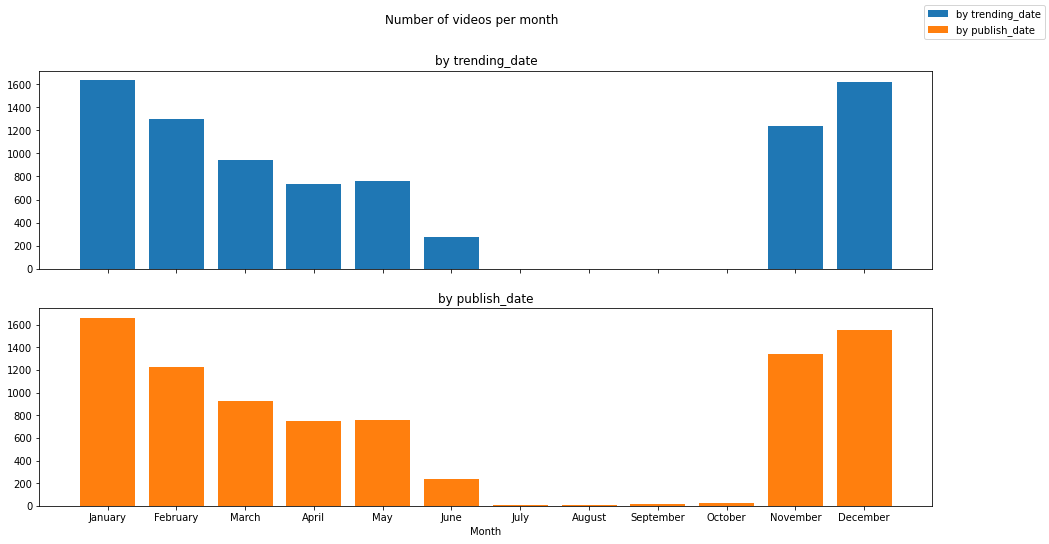

In [11]:
print("\n")
months_labels = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16, 8), sharex=True)
fig.suptitle("Number of videos per month")

data = df['tren_month'].value_counts(sort=False).sort_index()
months = data.keys()
ax1.set_title("by trending_date")
ax1.bar(months, data, color='tab:blue', label="by trending_date")


data = df['pub_month'].value_counts(sort=False).sort_index()
months = data.keys()
ax2.set_title("by publish_date")
ax2.bar(months, data, color='tab:orange', label="by publish_date")
ax2.set_xlabel ('Month')

    
# fig.text(0.04, 0.5, 'Number of videos', va='center', rotation='vertical')
fig.legend()
plt.xticks(ticks=np.arange(1, 13, 1), labels=months_labels)
plt.show()

### Różne statystyki liczbowe

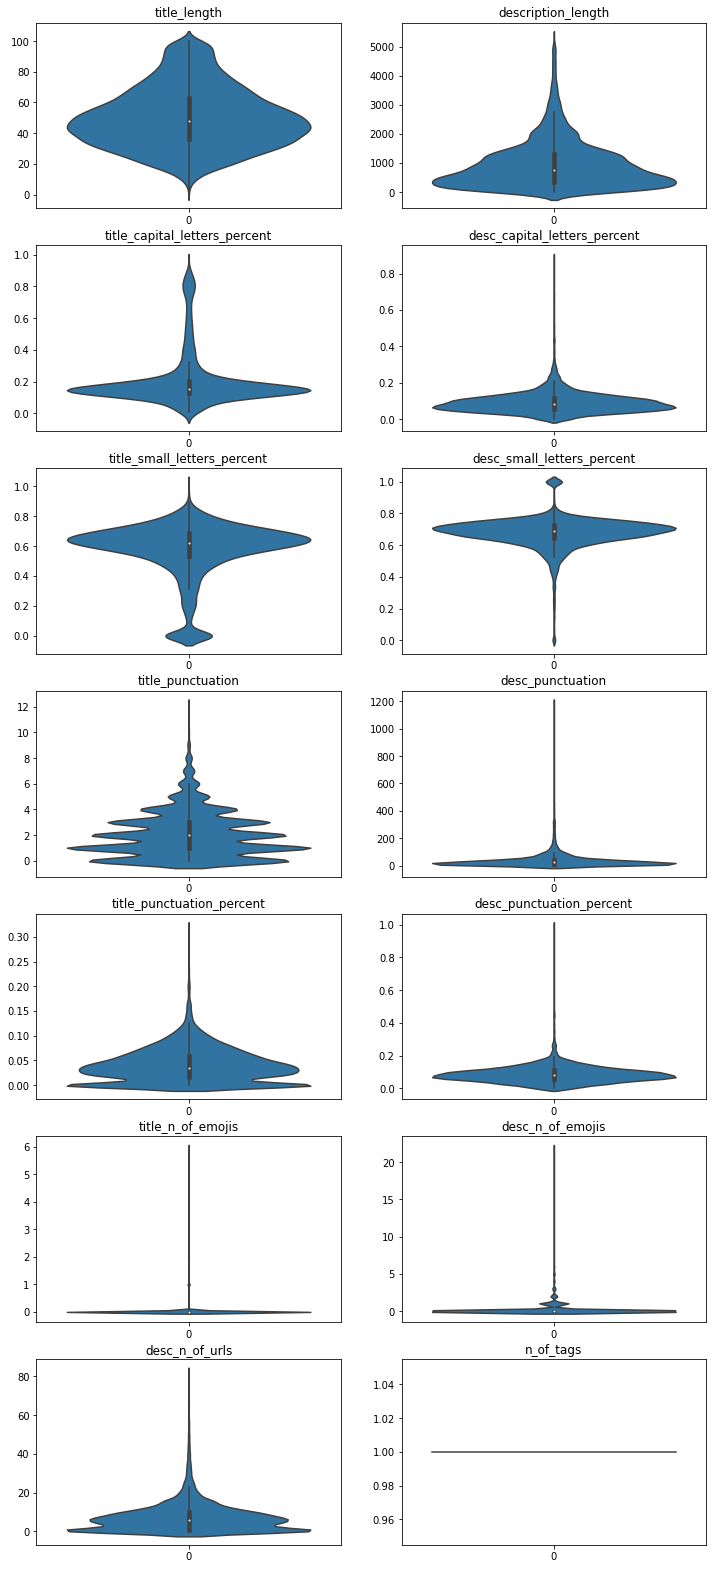

In [12]:
list_of_columns = [
    "title_length", "description_length", 
#     "title_capital_letters", "desc_capital_letters", 
    "title_capital_letters_percent", "desc_capital_letters_percent", 
#     "title_small_letters", "desc_small_letters", 
    "title_small_letters_percent",  "desc_small_letters_percent", 
    "title_punctuation", "desc_punctuation",
    "title_punctuation_percent", "desc_punctuation_percent",
    "title_n_of_emojis", "desc_n_of_emojis",
    "desc_n_of_urls",  "n_of_tags",
#     "likes", "dislikes",
#     "views", "comment_count"
                  ]
n_of_cols = 2
n_of_rows = int(len(list_of_columns)/n_of_cols)
fig, axes = plt.subplots(n_of_rows, n_of_cols, figsize=(n_of_cols*6, n_of_rows*4))

data = df.loc[:, list_of_columns]
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ax.set_title(list_of_columns[i*n_of_cols+j])
        sns.violinplot(ax=ax,data=df.loc[:, list_of_columns[i*n_of_cols+j]])

### 20 najpopularniejszych słów w tagach

In [13]:
all_tags_words = []
for tags in df.loc[:,"tags"]:
    tags = json.loads(tags.lower())
    single_words = ' '.join(tags).split(' ')
    all_tags_words.extend(single_words)
    
all_words_without_stopwords = [word for word in all_tags_words if word not in stopwords.words('english')]

wnl = WordNetLemmatizer()
all_words_lemmatized = [wnl.lemmatize(word) for word in all_words_without_stopwords]


cnt_tags = Counter(all_words_lemmatized)
cnt_tags = cnt_tags.most_common()

xx, yy = zip(*cnt_tags[:20])
plt.figure(figsize=(16,8))
sns.barplot(x=list(xx),y=list(yy))
plt.xlabel("Słowa")
plt.ylabel("Liczba wystąpień")
plt.title("Najpopularniejsze tagi")

Text(0.5, 1.0, 'Najpopularniejsze tagi')

### 20 najpopularniejszych słów w tytułach

In [14]:
def removePunctuationInString(text):
    new_text = [char for char in text if char not in string.punctuation]
    return ''.join(new_text)

all_words_title = []
for title in df.loc[:,"title"]:
    title = title.lower()
    single_words = title.split(' ')
    all_words_title.extend(single_words)
    
all_words_title = [removePunctuationInString(word) for word in all_words_title]
all_words_title_without_stopwords = [word for word in all_words_title if word not in stopwords.words('english') and word is not '']

wnl = WordNetLemmatizer()
all_words_title_lemmatized = [wnl.lemmatize(word) for word in all_words_title_without_stopwords]


cnt_title = Counter(all_words_title_lemmatized)
cnt_title = cnt_title.most_common()

xx, yy = zip(*cnt_title[:20])
plt.figure(figsize=(16,8))
sns.barplot(x=list(xx),y=list(yy))
plt.xlabel("Słowa")
plt.ylabel("Liczba wystąpień")
plt.title("Najpopularniejsze słowa w tytułach")

<>:12: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-14-af0667af41bc>:12: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  all_words_title_without_stopwords = [word for word in all_words_title if word not in stopwords.words('english') and word is not '']


Text(0.5, 1.0, 'Najpopularniejsze słowa w tytułach')

### Opis podstawowych statystyk dla wideo.
#### W statystyce znajdują się tylko pierwsze wystapienia wideo w liście trending 

,views,likes,dislikes,comment_count
count,8.511000e+03,8.511000e+03,8511.000000,8511.000000
mean,8.532400e+05,3.510220e+04,1433.996240,4321.517566
std,2.871308e+06,1.148402e+05,10868.021228,19332.913869
min,5.490000e+02,1.000000e+00,1.000000,1.000000
25%,7.851700e+04,1.873000e+03,66.000000,256.500000
50%,2.529580e+05,7.305000e+03,223.000000,877.000000
75%,7.462935e+05,2.465050e+04,753.000000,2822.500000
max,1.434082e+08,3.880074e+06,629123.000000,733371.000000


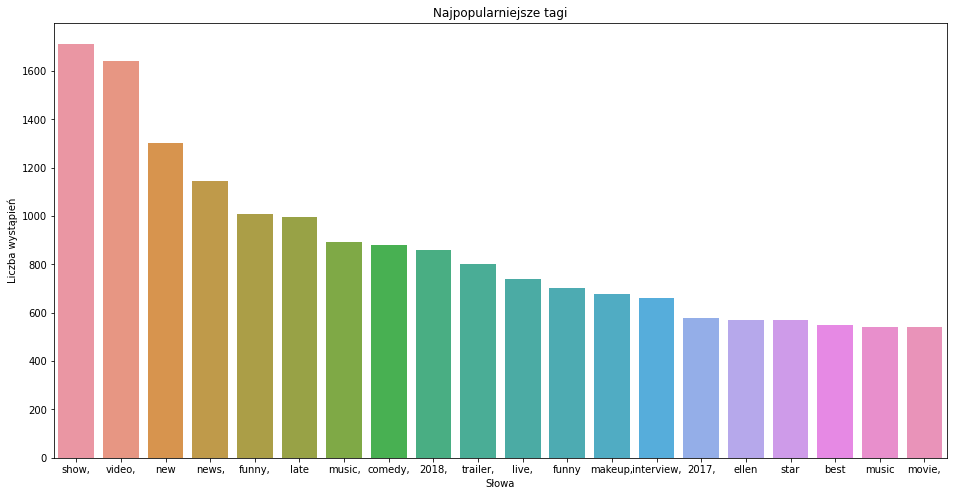

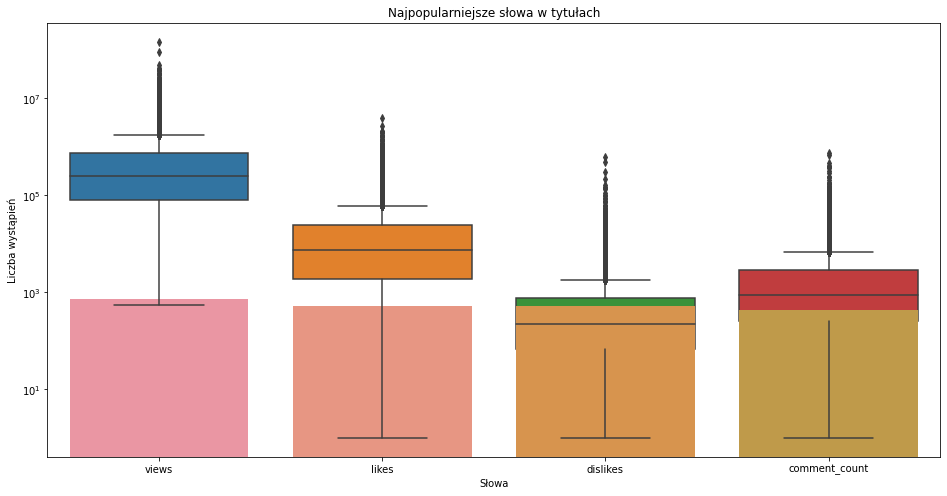

In [15]:

display(df.describe()[['views','likes','dislikes','comment_count']])

sns.set_style("whitegrid")
data = df[['views','likes','dislikes','comment_count']]
ax = sns.boxplot(data=data)
ax.set(yscale="log")
plt.show()

### Proporcje podstawowych statystyk.
#### W statystyce znajdują się tylko pierwsze wystapienia wideo w liście trending 

       dislikes/likes   likes/views  dislikes/views  comment_count/views
count     8511.000000  8.511000e+03    8.511000e+03         8.511000e+03
mean         0.117539  4.038739e-02    1.717411e-03         5.738950e-03
std          0.653514  3.513239e-02    4.492040e-03         7.001367e-03
min          0.000576  4.779704e-08    4.779704e-08         4.096206e-08
25%          0.014729  1.431155e-02    5.004004e-04         1.834752e-03
50%          0.030251  3.123913e-02    8.808122e-04         3.757032e-03
75%          0.071260  5.573426e-02    1.625712e-03         6.921055e-03
max         27.931818  2.956704e-01    2.155757e-01         1.176430e-01


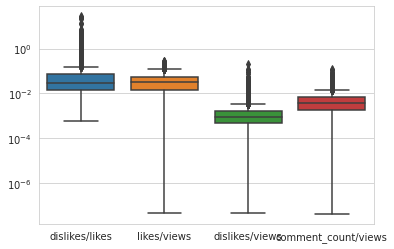

In [16]:
print(df.describe()[['dislikes/likes','likes/views','dislikes/views','comment_count/views']])

sns.set_style("whitegrid")
data = df[['dislikes/likes','likes/views','dislikes/views','comment_count/views']]
ax = sns.boxplot( data=data)
ax.set(yscale="log")
plt.show()

### Wzrost podstawowych statysyk po pierwszym wystąpieniu w trending 
#### Rozważamy filmy  które wystąpiłoy ponownie w trending

       increase_views  increase_likes  increase_dislikes  increase_comms
count    8.511000e+03    8.511000e+03        8511.000000     8511.000000
mean     2.791773e+05    6.725584e+03         538.730584      790.701680
std      1.882972e+06    4.040525e+04        7170.899533     6281.451085
min     -1.429083e+08   -2.550877e+06     -134410.000000  -132123.000000
25%      8.231500e+03    9.900000e+01           5.000000        7.000000
50%      5.949200e+04    8.960000e+02          53.000000       94.000000
75%      2.182105e+05    4.032000e+03         239.000000      424.000000
max      2.782687e+07    7.663000e+05      436649.000000   326280.000000


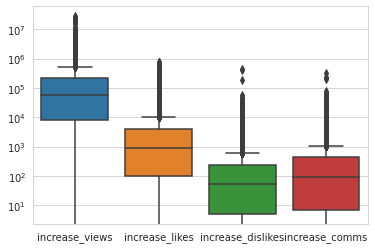

In [29]:
sns.set_style("whitegrid")
print(df.describe()[['increase_views','increase_likes','increase_dislikes','increase_comms']])

data = df[['increase_views','increase_likes','increase_dislikes','increase_comms']]
ax = sns.boxplot( data=data)
ax.set(yscale="log")
plt.show()


### Czas od publikacji do pierwszego wystąpienia w trending


,time_to_trend_in_days
count,8511.000000
mean,30.482535
std,244.241731
min,0.327847
25%,1.499965
50%,2.193079
75%,3.389884
max,4215.649861


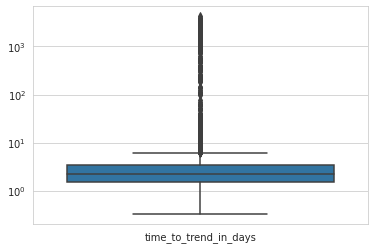

In [34]:
display(df.describe()[['time_to_trend_in_days']])

sns.set_style("whitegrid")
data = df[['time_to_trend_in_days']]
ax = sns.boxplot( data=data)
ax.set(yscale="log")
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'legend'

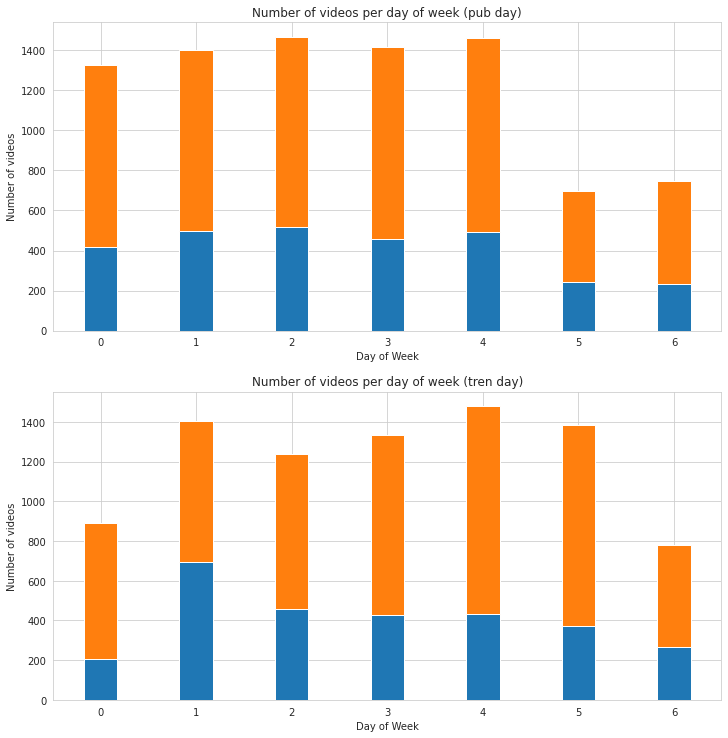

In [47]:
    data17 = df[df["tren_year"]==2017]['pub_day_of_the_week'].value_counts(sort=False)[df["pub_day_of_the_week"].unique()]
    data18 = df[df["tren_year"]==2018]['pub_day_of_the_week'].value_counts(sort=False)[df["pub_day_of_the_week"].unique()]

    days = data17.keys()#[0,6,4,5,3,1,2]


    fig, ax = plt.subplots(2,1,figsize=(10,10))
    fig.tight_layout(h_pad=4)
    ax[0].bar(days,data17,0.35,label="2017")
    ax[0].bar(days,data18,0.35,bottom=data17,label="2018")
    ax[0].set_xlabel ('Day of Week')
    ax[0].set_ylabel ('Number of videos')
    ax[0].set_title("Number of videos per day of week (pub day)")

    data17 = df[df["tren_year"]==2017]['tren_day_of_the_week'].value_counts(sort=False)[df["tren_day_of_the_week"].unique()]
    data18 = df[df["tren_year"]==2018]['tren_day_of_the_week'].value_counts(sort=False)[df["tren_day_of_the_week"].unique()]

    days = data17.keys()

    ax[1].bar(days,data17,0.35,label="2017")
    ax[1].bar(days,data18,0.35,bottom=data17,label="2018")
    ax[1].set_xlabel ('Day of Week')
    ax[1].set_ylabel ('Number of videos')
    ax[1].set_title("Number of videos per day of week (tren day)")

    plt.show()